Generating new MNIST digits with GAN

In [25]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below. np.random.seed(1000)
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

Step 1: Load the dataset

In [27]:

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)




Step 2: Build the generator model

In [33]:
generator = keras.models.Sequential(name='generator')
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 784)               80

Step 3: Build the discriminator model

In [34]:
discriminator = keras.models.Sequential(name='discriminator')
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)             

Step 4: Build GAN model = generator + discriminator

In [36]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
# Create a new model with the legacy optimizer
legacy_optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizer)
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 784)               1486352   
                                                                 
 discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


Step 5: Prepare functions to produce and plot the results

In [37]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for i in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of the most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)

        # Plot losses from every epoch
        plotLoss(e)


Step 6: Fit GAN model & plot reults

Epochs: 100
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|          | 1/468 [00:00<01:45,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


  0%|          | 2/468 [00:00<01:50,  4.22it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 3/468 [00:00<01:46,  4.37it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 4/468 [00:00<01:46,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 5/468 [00:01<01:49,  4.22it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 6/468 [00:01<01:48,  4.27it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:01<01:46,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 8/468 [00:01<01:44,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 9/468 [00:02<01:42,  4.48it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 10/468 [00:02<01:40,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 11/468 [00:02<01:43,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 12/468 [00:02<01:45,  4.31it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:03<01:50,  4.14it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 14/468 [00:03<01:46,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 15/468 [00:03<01:44,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 16/468 [00:03<01:46,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▎         | 17/468 [00:03<01:46,  4.22it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 18/468 [00:04<01:47,  4.19it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 19/468 [00:04<01:43,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 20/468 [00:04<01:41,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 21/468 [00:04<01:37,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 22/468 [00:05<01:36,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▍         | 23/468 [00:05<01:42,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▌         | 24/468 [00:05<01:44,  4.24it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 25/468 [00:05<01:44,  4.24it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 26/468 [00:05<01:39,  4.43it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 27/468 [00:06<01:40,  4.38it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 28/468 [00:06<01:41,  4.33it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 29/468 [00:06<01:43,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▋         | 30/468 [00:06<01:40,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 31/468 [00:07<01:38,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 32/468 [00:07<01:38,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 33/468 [00:07<01:38,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 34/468 [00:07<01:35,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 35/468 [00:07<01:33,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 36/468 [00:08<01:31,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 37/468 [00:08<01:31,  4.73it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 38/468 [00:08<01:33,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 39/468 [00:08<01:35,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 40/468 [00:09<01:36,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 41/468 [00:09<01:41,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 42/468 [00:09<01:54,  3.72it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 43/468 [00:10<01:59,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 44/468 [00:10<02:03,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 45/468 [00:10<02:09,  3.25it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 46/468 [00:10<02:11,  3.21it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 47/468 [00:11<02:12,  3.18it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 48/468 [00:11<02:13,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 10%|█         | 49/468 [00:11<02:14,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:12<02:12,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 51/468 [00:12<02:13,  3.11it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 52/468 [00:12<02:12,  3.14it/s]

4/4 [==============================] - 0s 11ms/step


 11%|█▏        | 53/468 [00:13<02:12,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 54/468 [00:13<02:13,  3.10it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▏        | 55/468 [00:13<02:05,  3.30it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 56/468 [00:14<01:57,  3.52it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 57/468 [00:14<01:47,  3.83it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 58/468 [00:14<01:40,  4.10it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 59/468 [00:14<01:35,  4.28it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 60/468 [00:14<01:32,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 61/468 [00:15<01:31,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 62/468 [00:15<01:29,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 63/468 [00:15<01:27,  4.63it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▎        | 64/468 [00:15<01:26,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 65/468 [00:15<01:26,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 66/468 [00:16<01:25,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▍        | 67/468 [00:16<01:27,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 68/468 [00:16<01:25,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▍        | 69/468 [00:16<01:26,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▍        | 70/468 [00:17<01:25,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▌        | 71/468 [00:17<01:27,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▌        | 72/468 [00:17<01:29,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 73/468 [00:17<01:27,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 74/468 [00:17<01:27,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 75/468 [00:18<01:28,  4.45it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 76/468 [00:18<01:29,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▋        | 77/468 [00:18<01:26,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 78/468 [00:18<01:28,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 79/468 [00:19<01:29,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 80/468 [00:19<01:27,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 81/468 [00:19<01:28,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 82/468 [00:19<01:28,  4.37it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 83/468 [00:19<01:26,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 84/468 [00:20<01:22,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 85/468 [00:20<01:21,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 86/468 [00:20<01:23,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▊        | 87/468 [00:20<01:21,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 88/468 [00:21<01:23,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 89/468 [00:21<01:23,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 90/468 [00:21<01:25,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 91/468 [00:21<01:22,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 92/468 [00:21<01:22,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 93/468 [00:22<01:23,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 94/468 [00:22<01:24,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 95/468 [00:22<01:21,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 96/468 [00:22<01:19,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 97/468 [00:23<01:18,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 98/468 [00:23<01:20,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 99/468 [00:23<01:23,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:23<01:21,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 101/468 [00:24<01:34,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 102/468 [00:24<01:42,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:24<01:45,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:25<01:50,  3.30it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 105/468 [00:25<01:50,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 106/468 [00:25<01:53,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 107/468 [00:26<01:55,  3.13it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 108/468 [00:26<01:58,  3.03it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 109/468 [00:26<01:59,  3.00it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▎       | 110/468 [00:27<01:58,  3.02it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▎       | 111/468 [00:27<01:57,  3.04it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 112/468 [00:27<01:55,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 113/468 [00:28<01:57,  3.03it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▍       | 114/468 [00:28<01:48,  3.26it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▍       | 115/468 [00:28<01:40,  3.51it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▍       | 116/468 [00:28<01:34,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 117/468 [00:28<01:30,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:29<01:29,  3.90it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 119/468 [00:29<01:27,  3.99it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 120/468 [00:29<01:23,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▌       | 121/468 [00:29<01:23,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 122/468 [00:30<01:18,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▋       | 123/468 [00:30<01:20,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 124/468 [00:30<01:16,  4.48it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 125/468 [00:30<01:17,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 126/468 [00:31<01:18,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 127/468 [00:31<01:15,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 128/468 [00:31<01:16,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 129/468 [00:31<01:15,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 130/468 [00:31<01:16,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 131/468 [00:32<01:16,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 132/468 [00:32<01:18,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 133/468 [00:32<01:15,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▊       | 134/468 [00:32<01:15,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 135/468 [00:33<01:12,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 136/468 [00:33<01:13,  4.50it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 137/468 [00:33<01:16,  4.32it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 138/468 [00:33<01:17,  4.27it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 139/468 [00:33<01:16,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 140/468 [00:34<01:16,  4.31it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 141/468 [00:34<01:14,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:34<01:14,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 143/468 [00:34<01:11,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 144/468 [00:35<01:09,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 145/468 [00:35<01:11,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 146/468 [00:35<01:14,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 147/468 [00:35<01:13,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 148/468 [00:35<01:11,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 149/468 [00:36<01:09,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 150/468 [00:36<01:09,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 151/468 [00:36<01:08,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 152/468 [00:36<01:07,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 153/468 [00:37<01:09,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 154/468 [00:37<01:10,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 155/468 [00:37<01:11,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 156/468 [00:37<01:09,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 157/468 [00:37<01:10,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 158/468 [00:38<01:18,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▍      | 159/468 [00:38<01:25,  3.62it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▍      | 160/468 [00:38<01:30,  3.41it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▍      | 161/468 [00:39<01:32,  3.31it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▍      | 162/468 [00:39<01:36,  3.17it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▍      | 163/468 [00:39<01:35,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 164/468 [00:40<01:35,  3.20it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▌      | 165/468 [00:40<01:36,  3.15it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 166/468 [00:40<01:35,  3.16it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 167/468 [00:41<01:34,  3.19it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 168/468 [00:41<01:32,  3.23it/s]

4/4 [==============================] - 0s 11ms/step


 36%|███▌      | 169/468 [00:41<01:33,  3.20it/s]

4/4 [==============================] - 0s 11ms/step


 36%|███▋      | 170/468 [00:42<01:31,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 171/468 [00:42<01:32,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 172/468 [00:42<01:29,  3.29it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 173/468 [00:42<01:23,  3.52it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 174/468 [00:43<01:19,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 175/468 [00:43<01:16,  3.84it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 176/468 [00:43<01:12,  4.05it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 177/468 [00:43<01:09,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 178/468 [00:44<01:09,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 179/468 [00:44<01:08,  4.21it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 180/468 [00:44<01:06,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▊      | 181/468 [00:44<01:04,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 182/468 [00:44<01:02,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 183/468 [00:45<01:01,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 184/468 [00:45<00:59,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 185/468 [00:45<00:59,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 186/468 [00:45<01:00,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 187/468 [00:46<01:01,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


 40%|████      | 188/468 [00:46<01:02,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████      | 189/468 [00:46<01:01,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 190/468 [00:46<00:59,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 191/468 [00:46<01:02,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 192/468 [00:47<01:03,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 193/468 [00:47<01:03,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████▏     | 194/468 [00:47<01:00,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 195/468 [00:47<01:00,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 196/468 [00:48<00:59,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 197/468 [00:48<01:00,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 198/468 [00:48<00:59,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 199/468 [00:48<01:00,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 200/468 [00:48<01:02,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 201/468 [00:49<01:00,  4.38it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 202/468 [00:49<01:01,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 203/468 [00:49<00:59,  4.42it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▎     | 204/468 [00:49<01:01,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 205/468 [00:50<01:01,  4.26it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 206/468 [00:50<01:01,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 207/468 [00:50<00:59,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 208/468 [00:50<00:58,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▍     | 209/468 [00:51<00:59,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 210/468 [00:51<00:57,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▌     | 211/468 [00:51<00:56,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▌     | 212/468 [00:51<00:55,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 213/468 [00:51<00:58,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 214/468 [00:52<00:58,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 215/468 [00:52<00:57,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 216/468 [00:52<00:58,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▋     | 217/468 [00:52<01:04,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 218/468 [00:53<01:07,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 219/468 [00:53<01:11,  3.48it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 220/468 [00:53<01:14,  3.31it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 221/468 [00:54<01:18,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 222/468 [00:54<01:16,  3.21it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 223/468 [00:54<01:15,  3.23it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 224/468 [00:55<01:18,  3.13it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 225/468 [00:55<01:18,  3.09it/s]

4/4 [==============================] - 0s 11ms/step


 48%|████▊     | 226/468 [00:55<01:17,  3.12it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▊     | 227/468 [00:56<01:20,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 228/468 [00:56<01:17,  3.10it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 229/468 [00:56<01:15,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [00:57<01:19,  2.98it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 231/468 [00:57<01:10,  3.38it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 232/468 [00:57<01:03,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 233/468 [00:57<01:01,  3.85it/s]

4/4 [==============================] - 0s 8ms/step


 50%|█████     | 234/468 [00:58<00:59,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 50%|█████     | 235/468 [00:58<00:58,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 50%|█████     | 236/468 [00:58<00:55,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 237/468 [00:58<00:52,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 238/468 [00:59<00:53,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 239/468 [00:59<00:52,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████▏    | 240/468 [00:59<00:50,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████▏    | 241/468 [00:59<00:49,  4.61it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 242/468 [00:59<00:48,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 243/468 [01:00<00:48,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 244/468 [01:00<00:50,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 245/468 [01:00<00:51,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 246/468 [01:00<00:50,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 247/468 [01:01<00:50,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 248/468 [01:01<00:50,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 249/468 [01:01<00:51,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 250/468 [01:01<00:49,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▎    | 251/468 [01:01<00:50,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 252/468 [01:02<00:49,  4.38it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 253/468 [01:02<00:49,  4.35it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 254/468 [01:03<01:15,  2.83it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 255/468 [01:03<01:09,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 256/468 [01:03<01:04,  3.29it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 257/468 [01:03<00:59,  3.56it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 258/468 [01:04<00:55,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 259/468 [01:04<00:54,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 260/468 [01:04<00:53,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 261/468 [01:04<00:52,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 262/468 [01:04<00:51,  4.02it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 263/468 [01:05<00:50,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


 56%|█████▋    | 264/468 [01:05<00:50,  4.03it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 265/468 [01:05<00:51,  3.97it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 266/468 [01:05<00:49,  4.05it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 267/468 [01:06<00:49,  4.09it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 268/468 [01:06<00:47,  4.22it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 269/468 [01:06<00:47,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 270/468 [01:06<00:48,  4.12it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 271/468 [01:07<00:48,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 272/468 [01:07<00:57,  3.41it/s]

4/4 [==============================] - 0s 12ms/step


 58%|█████▊    | 273/468 [01:07<01:00,  3.23it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▊    | 274/468 [01:08<01:01,  3.15it/s]

4/4 [==============================] - 0s 14ms/step


 59%|█████▉    | 275/468 [01:08<01:04,  2.98it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▉    | 276/468 [01:08<01:03,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 277/468 [01:09<01:02,  3.07it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 278/468 [01:09<01:03,  2.99it/s]

4/4 [==============================] - 0s 12ms/step


 60%|█████▉    | 279/468 [01:09<01:02,  3.01it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 280/468 [01:10<01:01,  3.03it/s]

4/4 [==============================] - 0s 8ms/step


 60%|██████    | 281/468 [01:10<01:01,  3.02it/s]

4/4 [==============================] - 0s 13ms/step


 60%|██████    | 282/468 [01:10<01:02,  3.00it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 283/468 [01:11<01:02,  2.98it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 284/468 [01:11<01:01,  2.99it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████    | 285/468 [01:11<00:54,  3.37it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████    | 286/468 [01:12<00:49,  3.69it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████▏   | 287/468 [01:12<00:47,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 288/468 [01:12<00:45,  3.94it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 289/468 [01:12<00:44,  4.02it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 290/468 [01:12<00:43,  4.08it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 291/468 [01:13<00:44,  4.02it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 292/468 [01:13<00:43,  4.03it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 293/468 [01:13<00:42,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 294/468 [01:13<00:41,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 295/468 [01:14<00:41,  4.21it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 296/468 [01:14<00:39,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 297/468 [01:14<00:39,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▎   | 298/468 [01:14<00:39,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 299/468 [01:15<00:38,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 300/468 [01:15<00:38,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 301/468 [01:15<00:38,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 302/468 [01:15<00:37,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▍   | 303/468 [01:16<00:38,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 304/468 [01:16<00:38,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▌   | 305/468 [01:16<00:36,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▌   | 306/468 [01:16<00:37,  4.36it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 307/468 [01:16<00:36,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 308/468 [01:17<00:35,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 309/468 [01:17<00:36,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 310/468 [01:17<00:36,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▋   | 311/468 [01:17<00:35,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 312/468 [01:18<00:35,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 313/468 [01:18<00:35,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 314/468 [01:18<00:35,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 315/468 [01:18<00:34,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 316/468 [01:19<00:35,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 317/468 [01:19<00:35,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 318/468 [01:19<00:35,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 319/468 [01:19<00:34,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 320/468 [01:19<00:33,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████▊   | 321/468 [01:20<00:34,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 322/468 [01:20<00:34,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:20<00:34,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 324/468 [01:20<00:34,  4.21it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 325/468 [01:21<00:32,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 326/468 [01:21<00:32,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 70%|██████▉   | 327/468 [01:21<00:31,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:21<00:35,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 329/468 [01:22<00:37,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 330/468 [01:22<00:40,  3.43it/s]

4/4 [==============================] - 0s 12ms/step


 71%|███████   | 331/468 [01:22<00:41,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 332/468 [01:23<00:42,  3.20it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 333/468 [01:23<00:43,  3.13it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████▏  | 334/468 [01:23<00:42,  3.15it/s]

4/4 [==============================] - 0s 12ms/step


 72%|███████▏  | 335/468 [01:24<00:42,  3.13it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 336/468 [01:24<00:42,  3.13it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 337/468 [01:24<00:41,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 338/468 [01:25<00:41,  3.15it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 339/468 [01:25<00:41,  3.13it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 340/468 [01:25<00:41,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:26<00:41,  3.09it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 342/468 [01:26<00:38,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 343/468 [01:26<00:35,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▎  | 344/468 [01:26<00:32,  3.87it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▎  | 345/468 [01:26<00:29,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 346/468 [01:27<00:29,  4.14it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 347/468 [01:27<00:29,  4.14it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 348/468 [01:27<00:29,  4.07it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▍  | 349/468 [01:27<00:28,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▍  | 350/468 [01:28<00:28,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 351/468 [01:28<00:27,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 352/468 [01:28<00:27,  4.23it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 353/468 [01:28<00:26,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 354/468 [01:29<00:26,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 355/468 [01:29<00:26,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 356/468 [01:29<00:26,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:29<00:25,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▋  | 358/468 [01:30<00:24,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 359/468 [01:30<00:25,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 360/468 [01:30<00:25,  4.22it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 361/468 [01:30<00:25,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 362/468 [01:30<00:24,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 363/468 [01:31<00:23,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 364/468 [01:31<00:24,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 365/468 [01:31<00:23,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 366/468 [01:31<00:23,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 367/468 [01:32<00:22,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▊  | 368/468 [01:32<00:22,  4.43it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 369/468 [01:32<00:22,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 370/468 [01:32<00:21,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 371/468 [01:32<00:21,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 372/468 [01:33<00:21,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 80%|███████▉  | 373/468 [01:33<00:21,  4.44it/s]

4/4 [==============================] - 0s 10ms/step


 80%|███████▉  | 374/468 [01:33<00:21,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 375/468 [01:33<00:20,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 80%|████████  | 376/468 [01:34<00:20,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████  | 377/468 [01:34<00:20,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:34<00:20,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████  | 379/468 [01:34<00:20,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████  | 380/468 [01:34<00:19,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████▏ | 381/468 [01:35<00:18,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 382/468 [01:35<00:19,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:35<00:18,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 384/468 [01:35<00:18,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 385/468 [01:36<00:18,  4.45it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 386/468 [01:36<00:20,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 387/468 [01:36<00:22,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:37<00:23,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 389/468 [01:37<00:25,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 390/468 [01:37<00:25,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▎ | 391/468 [01:38<00:25,  3.08it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 392/468 [01:38<00:24,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [01:38<00:24,  3.05it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 394/468 [01:39<00:24,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 395/468 [01:39<00:24,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:39<00:23,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 397/468 [01:40<00:23,  3.05it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 398/468 [01:40<00:24,  2.84it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 399/468 [01:40<00:22,  3.00it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 400/468 [01:41<00:20,  3.29it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████▌ | 401/468 [01:41<00:18,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████▌ | 402/468 [01:41<00:17,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 403/468 [01:41<00:16,  3.86it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▋ | 404/468 [01:41<00:15,  4.08it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 405/468 [01:42<00:14,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 406/468 [01:42<00:14,  4.20it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 407/468 [01:42<00:14,  4.24it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 408/468 [01:42<00:13,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 409/468 [01:43<00:13,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 410/468 [01:43<00:13,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 411/468 [01:43<00:12,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 412/468 [01:43<00:12,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 413/468 [01:44<00:12,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 414/468 [01:44<00:12,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▊ | 415/468 [01:44<00:11,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 416/468 [01:44<00:11,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▉ | 417/468 [01:44<00:11,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▉ | 418/468 [01:45<00:11,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████▉ | 419/468 [01:45<00:10,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 90%|████████▉ | 420/468 [01:45<00:10,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 421/468 [01:45<00:10,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 90%|█████████ | 422/468 [01:46<00:10,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 90%|█████████ | 423/468 [01:46<00:09,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 424/468 [01:46<00:09,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 425/468 [01:46<00:09,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 426/468 [01:46<00:09,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 427/468 [01:47<00:09,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 428/468 [01:47<00:09,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 429/468 [01:47<00:09,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 430/468 [01:47<00:09,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 431/468 [01:48<00:08,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 432/468 [01:48<00:08,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 433/468 [01:48<00:08,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 434/468 [01:48<00:07,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 435/468 [01:49<00:07,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


 93%|█████████▎| 436/468 [01:49<00:07,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 437/468 [01:49<00:07,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▎| 438/468 [01:49<00:07,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 439/468 [01:50<00:06,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 440/468 [01:50<00:06,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 441/468 [01:50<00:06,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 442/468 [01:50<00:06,  4.29it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 443/468 [01:51<00:06,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▍| 444/468 [01:51<00:06,  3.63it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 445/468 [01:51<00:06,  3.39it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▌| 446/468 [01:52<00:06,  3.21it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 447/468 [01:52<00:07,  2.95it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 448/468 [01:52<00:07,  2.81it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 449/468 [01:53<00:06,  2.85it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 450/468 [01:53<00:06,  2.89it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▋| 451/468 [01:53<00:06,  2.79it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 452/468 [01:54<00:05,  2.89it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 453/468 [01:54<00:05,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 454/468 [01:54<00:04,  3.00it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 455/468 [01:55<00:04,  3.03it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 456/468 [01:55<00:03,  3.39it/s]

4/4 [==============================] - 0s 7ms/step


 98%|█████████▊| 457/468 [01:55<00:02,  3.69it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 458/468 [01:55<00:02,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 459/468 [01:56<00:02,  4.07it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 460/468 [01:56<00:01,  4.11it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▊| 461/468 [01:56<00:01,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [01:56<00:01,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 463/468 [01:56<00:01,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 464/468 [01:57<00:00,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 465/468 [01:57<00:00,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 466/468 [01:57<00:00,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 467/468 [01:57<00:00,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


100%|██████████| 468/468 [01:58<00:00,  3.96it/s]

4/4 [==============================] - 0s 7ms/step


FileNotFoundError: ignored

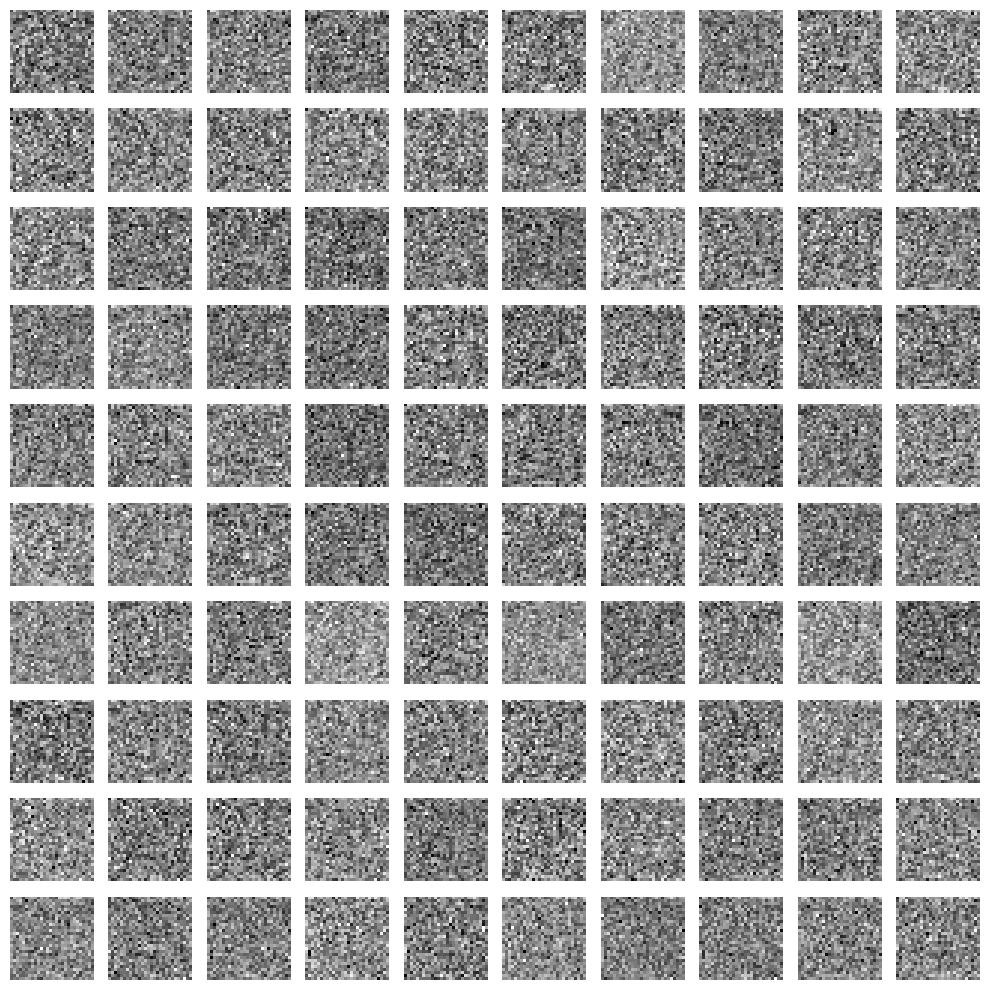

In [39]:
train(100, 128)